# Double-Bracket Iteration Strategy: Pauli-Z products

In this example, we demonstrate the usage of the DBI strategy: Pauli-Z products, where the diagonal operator is chosen as the optimal product of Pauli-Z operators.

In [1]:
from copy import copy, deepcopy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from qibo import hamiltonians, set_backend
from qibo.hamiltonians import Hamiltonian, SymbolicHamiltonian
from qibo.models.dbi.double_bracket import DoubleBracketGeneratorType, DoubleBracketIteration
from qibo.models.dbi.utils import *
from qibo.symbols import I, X, Z

In [2]:
def visualize_matrix(matrix, title=""):
    """Visualize absolute values of a matrix in a heatmap form."""
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_title(title)
    try:
        im = ax.imshow(np.absolute(matrix), cmap="inferno")
    except TypeError:
        im = ax.imshow(np.absolute(matrix.get()), cmap="inferno")
    fig.colorbar(im, ax=ax)


def visualize_drift(h0, h):
    """Visualize drift of the evolved hamiltonian w.r.t. h0."""
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_title(r"Drift: $|\hat{H}_0 - \hat{H}_{1}|$")
    try:
        im = ax.imshow(np.absolute(h0 - h), cmap="inferno")
    except TypeError:
        im = ax.imshow(np.absolute((h0 - h).get()), cmap="inferno")

    fig.colorbar(im, ax=ax)


def plot_histories(loss_histories: list, steps: list, labels: list = None):
    """Plot off-diagonal norm histories over a sequential evolution."""
    plt.figure(figsize=(5, 5 * 6 / 8))
    if len(steps) == 1:
        # fixed_step
        x_axis = [i * steps[0] for i in range(len(loss_histories))]
    else:
        x_axis = [sum(steps[:k]) for k in range(1, len(steps) + 1)]
    plt.plot(x_axis, loss_histories, "-o")

    x_labels_rounded = [round(x, 2) for x in x_axis]
    x_labels_rounded = [0] + x_labels_rounded[0:5] + [max(x_labels_rounded)]
    x_labels_rounded.pop(3)
    plt.xticks(x_labels_rounded)

    y_labels_rounded = [round(y, 1) for y in loss_histories]
    y_labels_rounded = y_labels_rounded[0:5] + [min(y_labels_rounded)]
    plt.yticks(y_labels_rounded)

    if labels is not None:
        labels_copy = copy(labels)
        labels_copy.insert(0, "Initial")
        for i, label in enumerate(labels_copy):
            plt.text(x_axis[i], loss_histories[i], label)

    plt.grid()
    plt.xlabel(r"Flow duration $s$")
    plt.title("Loss function histories")

## The initial setup

As an example, we consider the Transverse Field Ising Model (TFIM):
$$ H_{\rm TFIM} = - \sum_{i=1}^{N}\bigl( Z_i Z_{i+1} + h X_i \bigr),$$
which is already implemented in `Qibo`. For this tutorial we set $N=5$ and $h=3$.

In [3]:
# set the qibo backend (we suggest qibojit if N >= 20)
# alternatives: tensorflow (not optimized), numpy (when CPU not supported by jit)
set_backend("qibojit", "numba")

# hamiltonian parameters
nqubits = 5
h = 3

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# initialize class
# Note: use deepcopy to prevent h being edited
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator)
print("Initial off diagonal norm", dbi.off_diagonal_norm)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[Qibo 0.2.4|INFO|2024-01-05 14:12:53]: Using qibojit (numba) backend on /CPU:0


Initial off diagonal norm 37.94733192202055


## Local Z operators
Denoted as local Z operators, the diagonal operators used for this strategy are tensor products of pauli Z and identity.

In [7]:
generate_local_Z = generate_Z_operators(nqubits)
Z_ops = list(generate_local_Z.values())
Z_names = list(generate_local_Z.keys())

[Qibo 0.2.4|WARNING|2024-01-05 14:13:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.4|WARNING|2024-01-05 14:13:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.4|WARNING|2024-01-05 14:13:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.4|WARNING|2024-01-05 14:13:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.4|WARNING|2024-01-05 14:13:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.4|WARNING|2024-01-05 14:13:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.4|WARNING|2024-01-05 14:13:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.4|WARNING|2024-01-05 14:13:59]: Calculating the dens

## Iteration from list

In [9]:
NSTEPS = 10
Z_optimal = []
off_diagonal_norm_history = [dbi.off_diagonal_norm]
steps = [0]
for _ in range(NSTEPS):
    idx, step = select_best_dbr_generator_and_run(dbi, Z_ops, compare_canonical=False)
    off_diagonal_norm_history.append(dbi.off_diagonal_norm)
    steps.append(steps[-1]+step)
    if idx == len(Z_ops):
        Z_optimal.append("canonical")
    else:
        Z_optimal.append(Z_names[idx])
    print(f"New optimized step at iteration {_+1}/{NSTEPS}: {step} with operator {Z_optimal[-1]}")

New optimized step at iteration 1/10: 0.2228337317596202 with operator ZZZZI
New optimized step at iteration 2/10: 0.035477924096777136 with operator IIIZZ
New optimized step at iteration 3/10: 0.035172652127034264 with operator ZIIIZ
New optimized step at iteration 4/10: 0.05284947697359669 with operator IIZIZ
New optimized step at iteration 5/10: 0.05945391423239668 with operator ZIIIZ
New optimized step at iteration 6/10: 0.06722463454874757 with operator IZIII
New optimized step at iteration 7/10: 0.0004656172832855188 with operator IIIZZ
New optimized step at iteration 8/10: 0.0004368451128360077 with operator IIIZZ
New optimized step at iteration 9/10: 0.0004206499567262245 with operator IIIZZ
New optimized step at iteration 10/10: 0.0017291128494125731 with operator IIIZZ


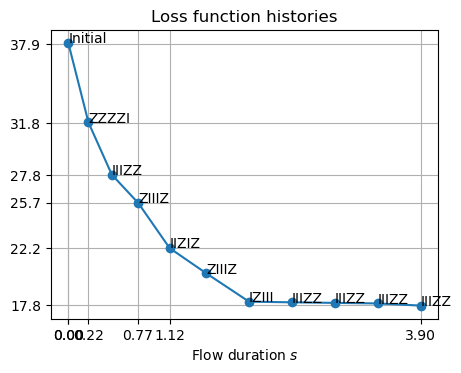

In [10]:
plot_histories(off_diagonal_norm_history, steps, Z_optimal)

It is worth noting that due to the nature of `hyperopt`, the iterations may be unstable and multiple runs may be required for the optimal result (alternatively, we can perform a grid search on the optimal step). Hence, it is sometimes needed to adjust its parameters including the following:

- step_min
- step_max
- max_evals

## Compare with canonical

In [11]:
# set the qibo backend (we suggest qibojit if N >= 20)
# alternatives: tensorflow (not optimized), numpy (when CPU not supported by jit)
set_backend("qibojit", "numba")


# initialize class|
# Note: use deepcopy to prevent h being edited
dbi_canonical = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.canonical)
print("Initial off diagonal norm", dbi_canonical.off_diagonal_norm)

[Qibo 0.2.4|INFO|2024-01-05 14:14:34]: Using qibojit (numba) backend on /CPU:0


Initial off diagonal norm 37.94733192202055


In [14]:
off_diagonal_norm_history_canonical = [dbi_canonical.off_diagonal_norm]
steps_canonical = [0]
steps_canonical_plot = [0]
for s in range(NSTEPS):
    step = dbi_canonical.hyperopt_step(
        step_min = 1e-5,
        step_max = 1,
        space = hp.uniform,
        optimizer = tpe,
        max_evals = 100,
    )
    print(f"New optimized step at iteration {s+1}/{NSTEPS}: {step}")
    dbi_canonical(step=step)
    off_diagonal_norm_history_canonical.append(dbi_canonical.off_diagonal_norm)
    steps_canonical.append(step)
    steps_canonical_plot.append(steps_canonical_plot[-1]+step)

New optimized step at iteration 1/10: 0.7142480688060842
New optimized step at iteration 2/10: 0.010872949360825475
New optimized step at iteration 3/10: 0.006641176164949921
New optimized step at iteration 4/10: 0.008158790292294325
New optimized step at iteration 5/10: 0.01138407139374301
New optimized step at iteration 6/10: 0.00599341515517138
New optimized step at iteration 7/10: 0.00804371900698387
New optimized step at iteration 8/10: 0.01154541035249238
New optimized step at iteration 9/10: 0.0066184869859390386
New optimized step at iteration 10/10: 0.011473689491291406


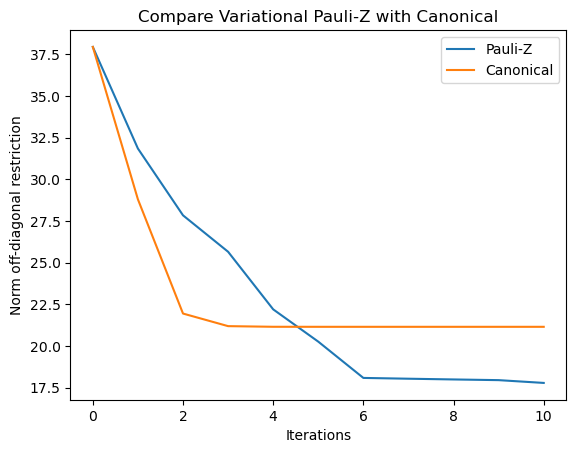

In [15]:
plt.figure()
# plt.plot(steps, off_diagonal_norm_history, label="Pauli-Z")
# plt.plot(steps_canonical, off_diagonal_norm_history_canonical, label="Canonical")
plt.plot(off_diagonal_norm_history, label="Pauli-Z")
plt.plot(off_diagonal_norm_history_canonical, label="Canonical")
plt.xlabel("Iterations")
plt.ylabel("Norm off-diagonal restriction")
plt.title("Compare Variational Pauli-Z with Canonical")
plt.legend()

Here we see that variationally chosen diagonal operators are less likely to converge to a local minimum compared to the GWW flow. 

## Mixed strategy

Since the canonical double bracket iteration performs better at the initial steps, we attempt to combine the two strategies: iterate a few steps using the canonical bracket before switching to the variational Z-operators.

In [27]:
dbi_mixed= DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.canonical)
print("Initial off diagonal norm", dbi_mixed.off_diagonal_norm)

Initial off diagonal norm 37.94733192202055


In [28]:
print(steps_canonical)
print(off_diagonal_norm_history_canonical)

[0, 0.7142480688060842, 0.010872949360825475, 0.006641176164949921, 0.008158790292294325, 0.01138407139374301, 0.00599341515517138, 0.00804371900698387, 0.01154541035249238, 0.0066184869859390386, 0.011473689491291406]
[37.94733192202055, 28.80143517496742, 21.948929896766895, 21.193262759184897, 21.15482325273987, 21.153158925755726, 21.15289717408808, 21.152893993520006, 21.152893840276587, 21.152893836578297, 21.152893836275403]


In [29]:
# Run the initial iterations using canonical iterations
off_diagonal_norm_history_mixed = [dbi_mixed.off_diagonal_norm]
steps_mixed = [0]
cannonical_NSTEPS = 2
for i in range(cannonical_NSTEPS):
    step = steps_canonical[i+1]
    dbi_mixed(step=step)
    off_diagonal_norm_history_mixed.append(dbi_mixed.off_diagonal_norm)
    steps_mixed.append(step)
    
print("After 2 steps, off diagonal norm:", dbi_mixed.off_diagonal_norm)
print("By comparison, the Pauli-Z:", off_diagonal_norm_history[2])

After 2 steps, off diagonal norm: 21.948929896766895
By comparison, the Pauli-Z: 27.84242666496467


In [30]:
# Continue the remaining steps with Pauli-Z operators
Z_optimal_mixed = ["Cannonical" for _ in range(cannonical_NSTEPS)]
remaining_NSTEPS = NSTEPS - cannonical_NSTEPS
dbi_mixed.mode = DoubleBracketGeneratorType.single_commutator
for _ in range(remaining_NSTEPS):
    idx, step = select_best_dbr_generator_and_run(dbi_mixed, Z_ops, compare_canonical=True)
    off_diagonal_norm_history_mixed.append(dbi_mixed.off_diagonal_norm)
    steps_mixed.append(step)
    if idx == len(Z_ops):
        Z_optimal_mixed.append("canonical")
    else:
        Z_optimal_mixed.append(Z_names[idx])
    print(f"New optimized step at iteration {_+1}/{remaining_NSTEPS}: {step} with operator {Z_optimal_mixed[-1]}")

New optimized step at iteration 1/8: 0.07026121386850952 with operator ZIZIZ
New optimized step at iteration 2/8: 0.0005119598708917606 with operator canonical
New optimized step at iteration 3/8: 3.6209008485931554e-05 with operator canonical
New optimized step at iteration 4/8: 0.0003966788691854405 with operator canonical
New optimized step at iteration 5/8: 1.0758355699794022e-05 with operator canonical
New optimized step at iteration 6/8: 9.815194330571166e-05 with operator canonical
New optimized step at iteration 7/8: 0.0004348171691943361 with operator canonical
New optimized step at iteration 8/8: 0.00010412633106159863 with operator canonical


In [31]:
print(off_diagonal_norm_history_mixed)
print(steps_mixed)
print(Z_optimal_mixed)

[37.94733192202055, 28.80143517496742, 21.948929896766895, 19.67268067670322, 19.356984750279484, 19.33716439273286, 19.127002740180895, 19.1217782200388, 19.07449837528649, 18.87464451203365, 18.83120737196001]
[0, 0.7142480688060842, 0.010872949360825475, 0.07026121386850952, 0.0005119598708917606, 3.6209008485931554e-05, 0.0003966788691854405, 1.0758355699794022e-05, 9.815194330571166e-05, 0.0004348171691943361, 0.00010412633106159863]
['Cannonical', 'Cannonical', 'ZIZIZ', 'canonical', 'canonical', 'canonical', 'canonical', 'canonical', 'canonical', 'canonical']


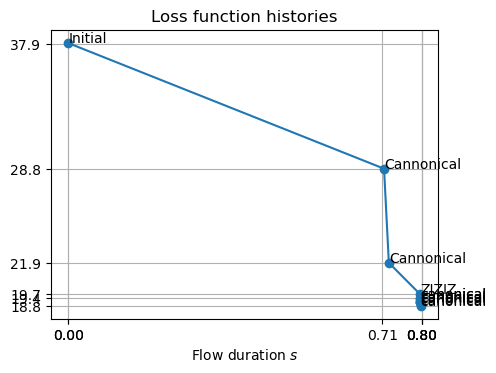

In [32]:
plot_histories(off_diagonal_norm_history_mixed, steps_mixed, Z_optimal_mixed)

We see that the mixed strategy does not necessarily give a better result, this could also be a result of the unstability of hyperopt.